In [1]:
# imports
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

### Read in data

The input data is the scrapped Padmapper Listings for the Year 2025 (so Jan 5 - Aug 20 2025). \
Columns are pretty self explanatory, with the amenities columns being 0/1 (for no/yes)

In [2]:
padmapper_path = "PadmapperData/Padmapper2025.xlsx"
df = pd.read_excel(padmapper_path)

Create a standardized version of price

In [3]:
# Divide Price by number of Beds since in padmapper it is standardized
df["StdPrice"] = np.where(
    df["Bed"] > 0,
    df["Price"] / df["Bed"],
    df["Price"]  # for studios, just use total SqFt since we can't divide by 0
)

### Rent vs Square Feet

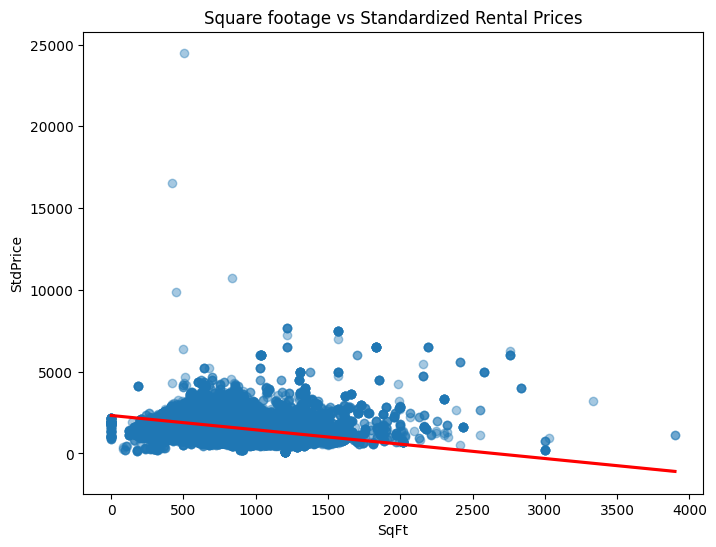

In [4]:
plt.figure(figsize=(8,6))
sns.regplot(data=df, x="SqFt", y="StdPrice", scatter_kws={'alpha':0.4}, line_kws={"color":"red"})
plt.title("Square footage vs Standardized Rental Prices")
plt.show()

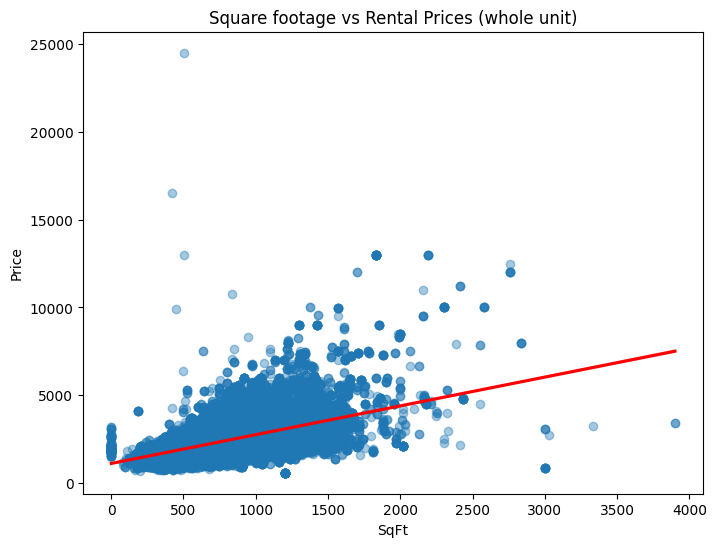

In [5]:
plt.figure(figsize=(8,6))
sns.regplot(data=df, x="SqFt", y="Price", scatter_kws={'alpha':0.4}, line_kws={"color":"red"})
plt.title("Square footage vs Rental Prices (whole unit)")
plt.show()

In [6]:
# Standardized SqFt
slope, intercept, r_value, p_value, std_err = stats.linregress(df["SqFt"], df["StdPrice"])
print("\nSqFt → Standardized Rent")
print(f"Line: y = {slope:.2f}x + {intercept:.2f}")
print(f"R² = {r_value**2:.4f}, p = {p_value:.4e}")



SqFt → Standardized Rent
Line: y = -0.88x + 2324.96
R² = 0.1211, p = 0.0000e+00


### Examining Amenities
Padmapper doesn't have parking in the data, will need to come up with the number from Entrata data

In [7]:
# Amenity Columns
amenity_cols = [
    "Fitness Center", "Swimming Pool", "In Unit Laundry"
]

# Calculate average rent for units with vs. without each amenity
amenity_summary = {}
for col in amenity_cols:
    amenity_summary[col] = df.groupby(col)["Price"].mean()

amenity_df = pd.DataFrame(amenity_summary).T
amenity_df.columns = ["No Amenity Avg Rent", "Amenity Avg Rent"]
amenity_df

,No Amenity Avg Rent,Amenity Avg Rent
Fitness Center,2135.057962,2478.897002
Swimming Pool,2194.653326,2571.099862
In Unit Laundry,2111.528633,2483.900806


### Run T-test to calculate if difference in means is statistically significant

In [8]:
t_test_results = []

for col in amenity_cols:
    group0 = df.loc[df[col] == 0, "Price"]
    group1 = df.loc[df[col] == 1, "Price"]
    
    # t-test (does not assume equal variance)
    t_stat, p_val = stats.ttest_ind(group0, group1, equal_var=False, nan_policy="omit")
    
    t_test_results.append({
        "Amenity": col,
        "Mean Rent (No)": group0.mean(),
        "Mean Rent (Yes)": group1.mean(),
        "Difference": group1.mean() - group0.mean(),
        "t-statistic": t_stat,
        "p-value": p_val
    })

t_test_df = pd.DataFrame(t_test_results).set_index("Amenity")
t_test_df


,Mean Rent (No),Mean Rent (Yes),Difference,t-statistic,p-value
Amenity,,,,,
Fitness Center,2135.057962,2478.897002,343.839040,-71.148916,0.0
Swimming Pool,2194.653326,2571.099862,376.446536,-68.590567,0.0
In Unit Laundry,2111.528633,2483.900806,372.372174,-78.738453,0.0


From above, it seems that fitness center (gym), pool, and laundry yielded higher average rental income than their counterparts which do not have these

### Loop over all Amenities

In [10]:
# Amenity columns
amenity_cols = [
    "Controlled Access","Fitness Center","Outdoor Space","Residents Lounge","Roof Deck","Storage",
    "Swimming Pool","Air Conditioning","Balcony","Furnished","Hardwood Floor","High Ceilings","In Unit Laundry"
]

results = []
for col in amenity_cols:
    # Coerce to 0/1
    x = df[col].fillna(0).astype(int)
    y = df["Price"]
    # Only proceed if we have both groups and sufficient observations
    if x.nunique() == 2 and y.notna().sum() > 20:
        group0 = y[x == 0].dropna()
        group1 = y[x == 1].dropna()
        if len(group0) > 5 and len(group1) > 5:
            t_stat, p_val = stats.ttest_ind(group0, group1, equal_var=False)
            diff = group1.mean() - group0.mean()
            results.append({"amenity": col, "Mean Rent (No)": group0.mean(), "Mean Rent (Yes)": group1.mean(), "mean_diff": diff, "p_value": p_val})

amenity_effects = pd.DataFrame(results).sort_values("mean_diff", ascending=False)
amenity_effects.reset_index(drop=True, inplace=True)
amenity_effects.head(20)


,amenity,Mean Rent (No),Mean Rent (Yes),mean_diff,p_value
0,Furnished,2273.175156,2730.453426,457.278270,0.000000e+00
1,Residents Lounge,2141.039436,2547.595673,406.556237,0.000000e+00
2,Roof Deck,2314.535002,2696.642934,382.107932,1.146179e-46
3,Swimming Pool,2194.653326,2571.099862,376.446536,0.000000e+00
4,In Unit Laundry,2111.528633,2483.900806,372.372174,0.000000e+00
5,Fitness Center,2135.057962,2478.897002,343.839040,0.000000e+00
6,Outdoor Space,2199.369114,2488.936222,289.567108,0.000000e+00
7,Storage,2168.097071,2398.101301,230.004229,0.000000e+00
8,Air Conditioning,2218.000917,2410.595919,192.595002,0.000000e+00
9,Hardwood Floor,2303.309681,2391.575213,88.265532,6.805652e-52


### Number of beds vs rent

                            OLS Regression Results                            
Dep. Variable:      Price per Bedroom   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     13.60
Date:                Mon, 01 Sep 2025   Prob (F-statistic):            0.00951
Time:                        17:57:53   Log-Likelihood:                -55.459
No. Observations:                   8   AIC:                             116.9
Df Residuals:                       5   BIC:                             117.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2018.3191    264.018      7.645      0.0

C:\Users\JackE\AppData\Local\Temp\ipykernel_1636\1301253211.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Equation": f"Rent = {model_poly.params[1]:.2f}*Beds + {model_poly.params[2]:.2f}*Beds^2 + {model_poly.params[0]:.2f}",


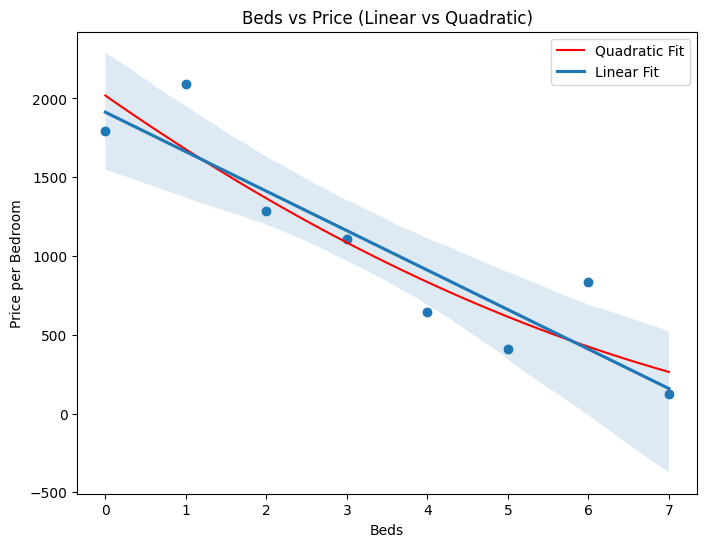

,Model,Line,R²,p-value,Equation,p-values
0,Linear,Rent = -250.60 * Age + 1912.45,0.832563,0.00157,NaN,NaN
1,Quadratic,NaN,0.844693,NaN,Rent = -356.48*Beds + 15.12*Beds^2 + 2018.32,"{'const': 0.0006095746679458775, 'x1': 0.09896..."


In [12]:
# Drop na's and take non-zero price
df_beds = df.dropna(subset=["Bed", "Price"])
df_beds = df_beds[df_beds["Price"] > 0]

# Standardize price
df_beds["Price per Bedroom"] = np.where(df_beds["Bed"] > 0, df_beds["Price"] / df_beds["Bed"], df_beds["Price"])

# Take the average based on the amount of beds
avg_per_bed = df_beds.groupby("Bed")["Price per Bedroom"].mean().reset_index()

# Linear Regression
slope, intercept, r_value, p_value, std_err = stats.linregress(
    avg_per_bed["Bed"], avg_per_bed["Price per Bedroom"]
)

regression_results = {
    "Line": f"Rent = {slope:.2f} * Age + {intercept:.2f}",
    "R²": r_value**2,
    "p-value": p_value
}

X = avg_per_bed["Bed"]
y = avg_per_bed["Price per Bedroom"]

X_poly = np.column_stack((X, X**2))
X_poly = sm.add_constant(X_poly) 
model_poly = sm.OLS(y, X_poly).fit()
print(model_poly.summary())

# Quadratic Regression
regression_results_poly = {
    "Equation": f"Rent = {model_poly.params[1]:.2f}*Beds + {model_poly.params[2]:.2f}*Beds^2 + {model_poly.params[0]:.2f}",
    "R²": model_poly.rsquared,
    "p-values": model_poly.pvalues.to_dict()
}

plt.figure(figsize=(8,6))
sns.scatterplot(x=X, y=y, s=60)

x_range = np.linspace(X.min(), X.max(), 100)
y_pred = model_poly.predict(sm.add_constant(np.column_stack((x_range, x_range**2))))
plt.plot(x_range, y_pred, color="red", label="Quadratic Fit")

sns.regplot(data=avg_per_bed, x="Bed", y="Price per Bedroom", scatter=False, label="Linear Fit")

plt.title("Beds vs Price (Linear vs Quadratic)")
plt.xlabel("Beds")
plt.ylabel("Price per Bedroom")
plt.legend()
plt.show()

results_df = pd.DataFrame([
    {"Model": "Linear", **regression_results},
    {"Model": "Quadratic", **regression_results_poly}
])

display(results_df)


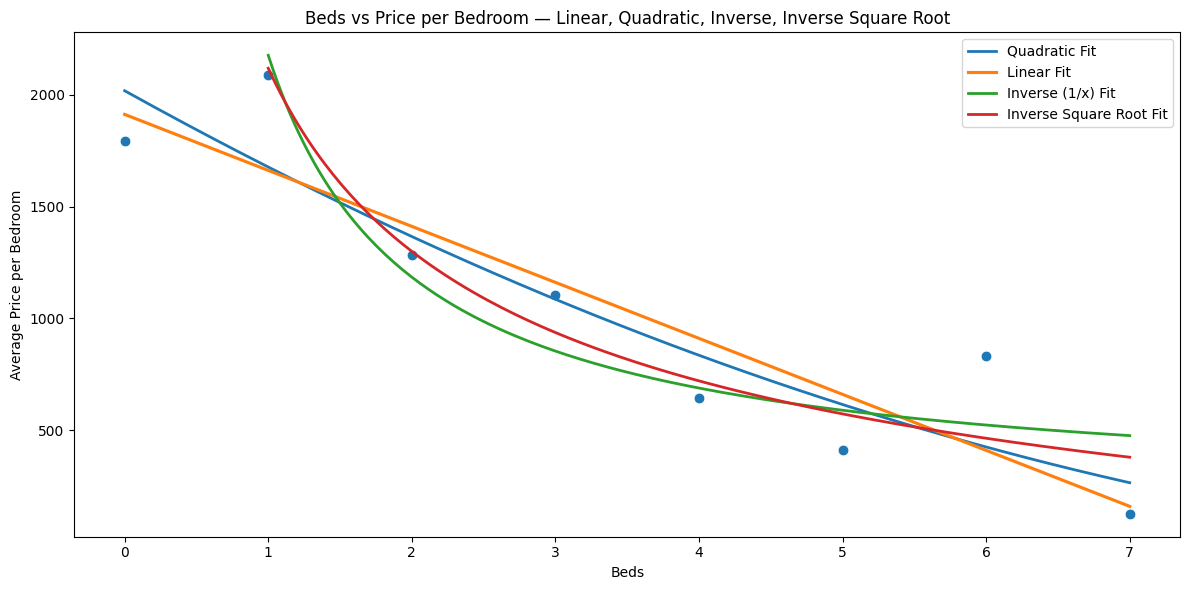

,Model,Equation,R²,p-values
0,Linear,Price/Bed = -250.6045·Beds + 1912.45,0.832563,{'Beds': 0.0015695003168818959}
1,Quadratic,Price/Bed = -356.4758·Beds + 15.1245·Beds² + 2...,0.844693,"{'const': 0.0006095746679458775, 'Beds': 0.098..."
2,Inverse (1/x),Price/Bed = 1985.8762·(1/Beds) + 191.22,0.866794,"{'const': 0.29039423523082164, '1/Beds': 0.002..."
3,Inverse √ (1/√x),Price/Bed = 2798.7726·(1/√Beds) + -679.64,0.895077,"{'const': 0.0479091252181992, '1/√Beds': 0.001..."


In [13]:
# Drop na's and take non-zero price
df_beds = df.dropna(subset=["Bed", "Price"])
df_beds = df_beds[df_beds["Price"] > 0]

# Standardize price
df_beds["Price per Bedroom"] = np.where(
    df_beds["Bed"] > 0, df_beds["Price"] / df_beds["Bed"], df_beds["Price"]
)

# Take the average based on the amount of beds
avg_per_bed = df_beds.groupby("Bed")["Price per Bedroom"].mean().reset_index()

slope, intercept, r_value, p_value, std_err = stats.linregress(
    avg_per_bed["Bed"], avg_per_bed["Price per Bedroom"]
)
regression_results = {
    "Model": "Linear",
    "Equation": f"Price/Bed = {slope:.4f}·Beds + {intercept:.2f}",
    "R²": r_value**2,
    "p-values": {"Beds": p_value}  # simple linregress has one slope p-value
}

X = avg_per_bed["Bed"].values
y = avg_per_bed["Price per Bedroom"].values

X_poly = np.column_stack((X, X**2))
X_poly = sm.add_constant(X_poly)
model_poly = sm.OLS(y, X_poly).fit()

regression_results_poly = {
    "Model": "Quadratic",
    "Equation": (
        f"Price/Bed = {model_poly.params[1]:.4f}·Beds "
        f"+ {model_poly.params[2]:.4f}·Beds² + {model_poly.params[0]:.2f}"
    ),
    "R²": float(model_poly.rsquared),
    "p-values": {
        "const": float(model_poly.pvalues[0]),
        "Beds": float(model_poly.pvalues[1]),
        "Beds^2": float(model_poly.pvalues[2]),
    }
}

#Inverse (1/x) and Inverse Square-Root
# Exclude Bed == 0 for these transforms
mask_pos = avg_per_bed["Bed"] > 0
X_pos = avg_per_bed.loc[mask_pos, "Bed"].values
y_pos = avg_per_bed.loc[mask_pos, "Price per Bedroom"].values

# Inverse (1/x): Price/Bed = a + b*(1/Beds)
X_inv = sm.add_constant((1.0 / X_pos).reshape(-1, 1))
model_inv = sm.OLS(y_pos, X_inv).fit()
eq_inv = f"Price/Bed = {model_inv.params[1]:.4f}·(1/Beds) + {model_inv.params[0]:.2f}"
regression_results_inv = {
    "Model": "Inverse (1/x)",
    "Equation": eq_inv,
    "R²": float(model_inv.rsquared),
    "p-values": {
        "const": float(model_inv.pvalues[0]),
        "1/Beds": float(model_inv.pvalues[1]),
    }
}

# Inverse square-root (1/sqrt(x)): Price/Bed = a + b*(1/√Beds)
X_isr_feat = (1.0 / np.sqrt(X_pos)).reshape(-1, 1)
X_isr = sm.add_constant(X_isr_feat)
model_isr = sm.OLS(y_pos, X_isr).fit()
eq_isr = f"Price/Bed = {model_isr.params[1]:.4f}·(1/√Beds) + {model_isr.params[0]:.2f}"
regression_results_isr = {
    "Model": "Inverse √ (1/√x)",
    "Equation": eq_isr,
    "R²": float(model_isr.rsquared),
    "p-values": {
        "const": float(model_isr.pvalues[0]),
        "1/√Beds": float(model_isr.pvalues[1]),
    }
}

# --- Plot: all four fits on one chart ---
plt.figure(figsize=(12,6))

# Scatter of the averaged data
sns.scatterplot(data=avg_per_bed, x="Bed", y="Price per Bedroom", s=60)

# Quadratic curve
x_range = np.linspace(X.min(), X.max(), 200)
y_quad = model_poly.predict(sm.add_constant(np.column_stack((x_range, x_range**2))))
plt.plot(x_range, y_quad, label="Quadratic Fit", linewidth=2)

# Linear line (reuse your seaborn regplot for convenience)
sns.regplot(
    data=avg_per_bed,
    x="Bed",
    y="Price per Bedroom",
    scatter=False,
    label="Linear Fit",
    ci=None
)

# Inverse (1/x) curve (only defined for Beds>0)
x_range_pos = np.linspace(max(1e-6, X_pos.min()), X_pos.max(), 200)
y_inv = model_inv.predict(sm.add_constant((1.0 / x_range_pos)))
plt.plot(x_range_pos, y_inv, label="Inverse (1/x) Fit", linewidth=2)

# Inverse square-root curve (only defined for Beds>0)
y_isr = model_isr.predict(sm.add_constant(1.0 / np.sqrt(x_range_pos)))
plt.plot(x_range_pos, y_isr, label="Inverse Square Root Fit", linewidth=2)


plt.title("Beds vs Price per Bedroom — Linear, Quadratic, Inverse, Inverse Square Root")
plt.xlabel("Beds")
plt.ylabel("Average Price per Bedroom")
plt.legend()
plt.tight_layout()
plt.show()

results_df = pd.DataFrame([
    regression_results,
    regression_results_poly,
    regression_results_inv,
    regression_results_isr
])[["Model", "Equation", "R²", "p-values"]]

display(results_df)


### Bedrooms and Bathrooms

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

# Use Padmapper columns
target = "StdPrice"
feat_cols = ["Bed", "Bath"]

# Drop rows with missing or zero price/beds/baths
mod = df[feat_cols + [target]].dropna()
mod = mod[(mod["StdPrice"] > 0) & (mod["Bed"] > 0) & (mod["Bath"] > 0)]

# Grouped view: median price by bed/bath
gb = mod.groupby(["Bed", "Bath"], dropna=False)["StdPrice"].median().reset_index().sort_values(["Bed", "Bath"])

# Regression
X = mod[feat_cols].values
y = mod[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
print("R^2:", round(r2_score(y_test, pred), 3), "| MAE:", round(mean_absolute_error(y_test, pred), 2))
print("Coefficients:", dict(zip(feat_cols, lr.coef_)))

R^2: 0.412 | MAE: 374.54
Coefficients: {'Bed': -683.6424441777777, 'Bath': 174.55452845484072}


In [15]:
df_beds = df.dropna(subset=["Bed", "Bath", "StdPrice"])
df_beds = df_beds[df_beds["StdPrice"] > 0]

# df_beds["Price per Bedroom"] = np.where(
#     df_beds["Bed"] > 0,
#     df_beds["Price"] / df_beds["Bed"],
#     df_beds["Price"]
# )

y = df_beds["StdPrice"]
X = df_beds[["Bed", "Bath"]]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               StdPrice   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                 1.969e+04
Date:                Mon, 01 Sep 2025   Prob (F-statistic):               0.00
Time:                        17:58:26   Log-Likelihood:            -8.4843e+05
No. Observations:              110219   AIC:                         1.697e+06
Df Residuals:                  110216   BIC:                         1.697e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2219.9007      4.750    467.392      0.0

In [16]:
# Add squared terms
df_beds["Bed^2"] = df_beds["Bed"]**2
df_beds["Bath^2"] = df_beds["Bath"]**2

X_quad = df_beds[["Bed", "Bath", "Bed^2", "Bath^2"]]
X_quad = sm.add_constant(X_quad)

model_quad = sm.OLS(y, X_quad).fit()
print(model_quad.summary())


                            OLS Regression Results                            
Dep. Variable:               StdPrice   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                 1.172e+04
Date:                Mon, 01 Sep 2025   Prob (F-statistic):               0.00
Time:                        17:58:32   Log-Likelihood:            -8.4573e+05
No. Observations:              110219   AIC:                         1.691e+06
Df Residuals:                  110214   BIC:                         1.692e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2472.8978     16.901    146.316      0.0

In [17]:
df_beds["Bed*Bath"] = df_beds["Bed"] * df_beds["Bath"]

X_inter = df_beds[["Bed", "Bath", "Bed*Bath"]]
X_inter = sm.add_constant(X_inter)

model_inter = sm.OLS(y, X_inter).fit()
print(model_inter.summary())


                            OLS Regression Results                            
Dep. Variable:               StdPrice   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                 1.315e+04
Date:                Mon, 01 Sep 2025   Prob (F-statistic):               0.00
Time:                        17:58:35   Log-Likelihood:            -8.4840e+05
No. Observations:              110219   AIC:                         1.697e+06
Df Residuals:                  110215   BIC:                         1.697e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2316.7830     13.787    168.038      0.0

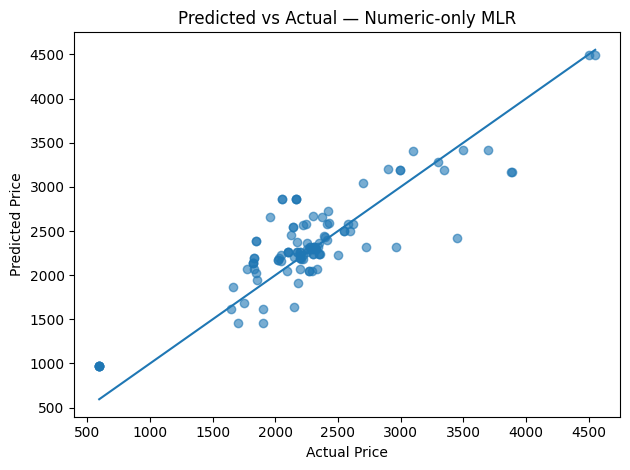

Top 10 features by |coef| (standardized inputs):
3. SqFt: coef=335.1239, |coef|=335.1239
2. Bath: coef=217.4459, |coef|=217.4459
1. Bed: coef=-204.6084, |coef|=204.6084
4. Pets: coef=197.8887, |coef|=197.8887
5. Location: coef=197.0724, |coef|=197.0724
14. Balcony: coef=195.9202, |coef|=195.9202
8. Outdoor Space: coef=-152.2343, |coef|=152.2343
15. Furnished: coef=-150.8401, |coef|=150.8401
18. In Unit Laundry: coef=91.6427, |coef|=91.6427
7. Fitness Center: coef=-79.1040, |coef|=79.1040

Metrics:
                          model  r2_test  rmse_test   mae_test  rows_used  features_used
LinearRegression (numeric-only) 0.769169 310.741844 222.239694        570             18


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

df = pd.read_excel("PadmapperData/Padmapper2025.xlsx")
df = df[df["Neighbourhood"] == "Downtown Waterloo"]
df["Latitude"] = pd.to_numeric(df["Latitude"], errors="coerce")
df["Longitude"] = pd.to_numeric(df["Longitude"], errors="coerce")
loc_mask = df["Latitude"].notna() & df["Longitude"].notna()
df["Location"] = np.nan

if loc_mask.sum() >= 2:
    X_loc = np.c_[df.loc[loc_mask, "Latitude"].values, df.loc[loc_mask, "Longitude"].values]
    pc1 = PCA(n_components=1, random_state=42).fit_transform(X_loc).ravel()
    pc1 = (pc1 - pc1.mean()) / (pc1.std() + 1e-12)
    df.loc[loc_mask, "Location"] = pc1

target_col = "Price"
df = df.dropna(subset=[target_col])
df = df[df[target_col] > 0]

candidates = [
    "Bed","Bath","SqFt","Pets", "Location"
    # "Latitude","Longitude"
]

amenity_cols = [
    "Controlled Access","Fitness Center","Outdoor Space","Residents Lounge","Roof Deck","Storage",
    "Swimming Pool","Air Conditioning","Balcony","Furnished","Hardwood Floor","High Ceilings","In Unit Laundry"
]
feature_cols = candidates + amenity_cols

X = df[feature_cols].copy().replace({np.inf: np.nan, -np.inf: np.nan})
y = df[target_col].astype(float)

for c in feature_cols:
    if X[c].isna().any():
        X[c] = X[c].fillna(X[c].median())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)
metrics = {
    "model": "LinearRegression (numeric-only)",
    "r2_test": r2_score(y_test, y_pred),
    "rmse_test": root_mean_squared_error(y_test, y_pred),
    "mae_test": mean_absolute_error(y_test, y_pred),
    "rows_used": len(df),
    "features_used": len(feature_cols)
}
metrics_df = pd.DataFrame([metrics])

coef_df = pd.DataFrame({"feature": feature_cols, "coef": lr.coef_})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)

# Plot predicted vs actual
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.6)
miv, mav = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([miv, mav], [miv, mav])
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual — Numeric-only MLR")
plt.tight_layout()
plt.show()

print("Top 10 features by |coef| (standardized inputs):")
for i, row in coef_df.head(10).iterrows():
    print(f"{i+1}. {row['feature']}: coef={row['coef']:.4f}, |coef|={row['abs_coef']:.4f}")

print("\nMetrics:")
print(metrics_df.to_string(index=False))


In [2]:
import statsmodels.api as sm

# Use the same scaled features as in your MLR
feature_cols = ["Furnished", "Swimming Pool", "Location", "In Unit Laundry", "SqFt", "Bed", "Bath"]
target_col = "Price"
X = df[feature_cols].copy().replace({np.inf: np.nan, -np.inf: np.nan})
y = df[target_col].astype(float)
X_all = scaler.fit_transform(X)
X_all = sm.add_constant(X_all)  # add intercept
model = sm.OLS(y, X_all).fit()

# Show summary with p-values
print(model.summary())

# If you want a sorted list of features by p-value:
feature_names = ['Intercept'] + feature_cols
pvals = model.pvalues
pval_df = pd.DataFrame({'feature': feature_names, 'p-value': pvals})
print(pval_df.sort_values('p-value'))

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     152.8
Date:                Fri, 05 Sep 2025   Prob (F-statistic):          1.17e-125
Time:                        17:38:17   Log-Likelihood:                -4172.5
No. Observations:                 570   AIC:                             8361.
Df Residuals:                     562   BIC:                             8396.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2328.2956     15.418    151.010      0.0

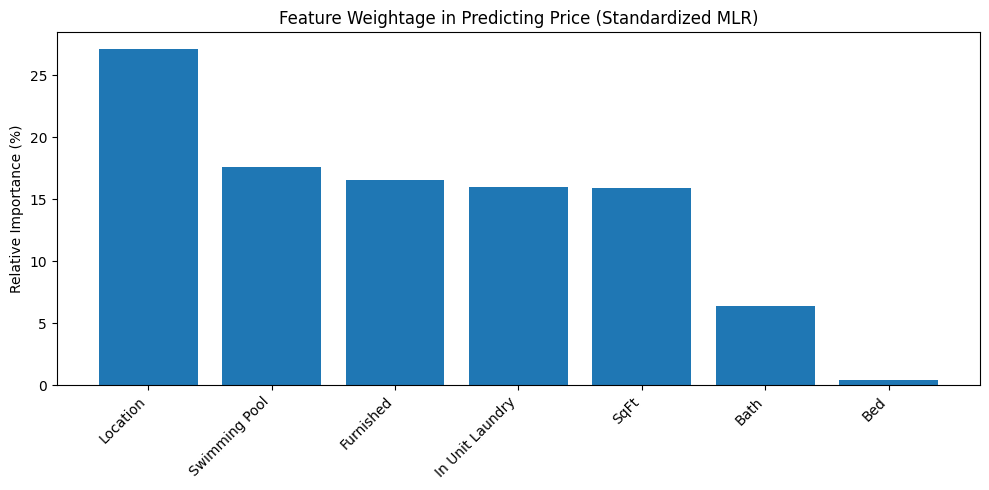

           feature        coef  weight_pct
2         Location  335.123859   27.109099
1    Swimming Pool  217.445943   17.589806
0        Furnished -204.608404   16.551341
3  In Unit Laundry  197.888708   16.007767
4             SqFt  197.072443   15.941737
6             Bath  -79.103959    6.398939
5              Bed   -4.961040    0.401312


In [3]:
coef_df = pd.DataFrame(list(zip(feature_cols, lr.coef_)), columns=["feature", "coef"])
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df["weight_pct"] = 100 * coef_df["abs_coef"] / coef_df["abs_coef"].sum()
coef_df = coef_df.sort_values("weight_pct", ascending=False)

# Bar plot of percentage weightage
plt.figure(figsize=(10,5))
plt.bar(coef_df["feature"], coef_df["weight_pct"])
plt.xticks(rotation=45, ha='right')
plt.ylabel("Relative Importance (%)")
plt.title("Feature Weightage in Predicting Price (Standardized MLR)")
plt.tight_layout()
plt.show()

# Print table for reference
print(coef_df[["feature", "coef", "weight_pct"]])

C:\Users\JackE\AppData\Local\Temp\ipykernel_23996\1666294747.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['dpwxpr', 'dpwxpr', 'dpwxr6', 'dpwxr6', 'dpwxpr', 'dpwxpr', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr6', 'dpwxr6', 'dpwxr6', 'dpwxr6', 'dpwxr3', 'dpwxr3', 'dpwxr3', 'dpwxre', 'dpwxre', 'dpwxr7', 'dpwxr7', 'dpwxr2', 'dpwxr2', 'dpwxr2', 'dpwxrc', 'dpwxr8', 'dpwxr8', 'dpwxr8', 'dpwxr8', 'dpwxr8', 'dpwxr2', 'dpwxr2', 'dpwxr2', 'dpwxr2', 'dpwxr2', 'dpwxpr', 'dpwxpr', 'dpwxpr', 'dpwxpr', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr6', 'dpwxr6', 'dpwxpr', 'dpwxpr', 'dpwxr6', 'dpwxr6', 'dpwxr6', 'dpwxr6', 'dpwxr3', 'dpwxr3', 'dpwxr3', 'dpwxre', 'dpwxre', 'dpwxr7', 'dpwxr7', 'dpwxpr', 'd

Random Forest R^2: 0.978
Random Forest MAE: 63.06


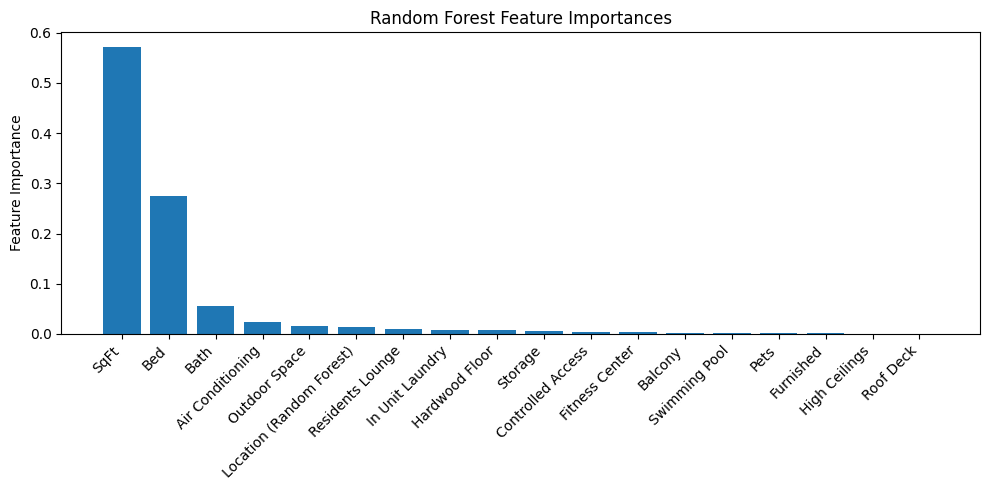

                     feature  importance
2                       SqFt    0.571824
0                        Bed    0.275368
1                       Bath    0.055628
12          Air Conditioning    0.023285
7              Outdoor Space    0.015701
4   Location (Random Forest)    0.014406
8           Residents Lounge    0.010242
17           In Unit Laundry    0.008099
15            Hardwood Floor    0.007113
10                   Storage    0.005962
5          Controlled Access    0.004226
6             Fitness Center    0.003002
13                   Balcony    0.001717
11             Swimming Pool    0.001359
3                       Pets    0.001090
14                 Furnished    0.000978
16             High Ceilings    0.000000
9                  Roof Deck    0.000000


In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# Encode geohash and turn into a single integer code
_BASE32 = "0123456789bcdefghjkmnpqrstuvwxyz"
def geohash_encode(lat, lon, precision=6):
    lat_interval = [-90.0, 90.0]
    lon_interval = [-180.0, 180.0]
    bits = [16, 8, 4, 2, 1]
    even, bit, ch, out = True, 0, 0, []
    for _ in range(precision*5):
        if even:
            mid = sum(lon_interval)/2
            go_high = lon > mid
            lon_interval[0 if go_high else 1] = mid
        else:
            mid = sum(lat_interval)/2
            go_high = lat > mid
            lat_interval[0 if go_high else 1] = mid
        ch |= bits[bit] if go_high else 0
        even = not even; bit += 1
        if bit == 5:
            out.append(_BASE32[ch]); bit = 0; ch = 0
        if len(out) == precision:
            break
    return "".join(out)

_locmask = df["Latitude"].notna() & df["Longitude"].notna()

precision = 6
df["geohash6"] = np.nan
df.loc[_locmask, "geohash6"] = [
    geohash_encode(a, b, precision) for a, b in zip(df.loc[_locmask, "Latitude"], df.loc[_locmask, "Longitude"])
]

# Single numeric column from the category (keeps “one feature”)
df["Location (Random Forest)"] = pd.Categorical(df["geohash6"]).codes  # -1 if NaN

# Use geohash6_code as your single location feature
feature_cols_rf = [
    "Bed","Bath","SqFt","Pets",
    # "Latitude","Longitude",
    "Location (Random Forest)"
] + amenity_cols

# Rebuild X and reuse indices
X_all = df[feature_cols_rf].copy().replace({np.inf: np.nan, -np.inf: np.nan})
for c in feature_cols_rf:
    if X_all[c].isna().any():
        X_all[c] = X_all[c].fillna(X_all[c].median())

X_train_rf = X_all.loc[X_train.index]
X_test_rf  = X_all.loc[X_test.index]

# Train RF and view importances
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_rf, y_train)
rf_pred = rf.predict(X_test_rf)

print("Random Forest R^2:", round(r2_score(y_test, rf_pred), 3))
print("Random Forest MAE:", round(mean_absolute_error(y_test, rf_pred), 2))

rf_importance_df = pd.DataFrame({
    "feature": feature_cols_rf,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

plt.figure(figsize=(10,5))
plt.bar(rf_importance_df["feature"], rf_importance_df["importance"])
plt.xticks(rotation=45, ha='right')
plt.ylabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

print(rf_importance_df)


### Random Forest
Doing a random forest again on comparable listings to our UW Properties and seeing if the same conclusions hold

C:\Users\JackE\AppData\Local\Temp\ipykernel_18540\561443385.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['dpwxpr', 'dpwxpr', 'dpwxr6', 'dpwxr6', 'dpwxr0', 'dpwxr0', 'dpwz2k', 'dpwz2k', 'dpwz2k', 'dpwxpr', 'dpwxpr', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwxr9', 'dpwz2m', 'dpwz2m', 'dpwz2m', 'dpwxr6', 'dpwxr6', 'dpwxr6', 'dpwxr6', 'dpwxrh', 'dpwxrh', 'dpwxrh', 'dpwxrh', 'dpwxrh', 'dpwxr3', 'dpwxr3', 'dpwxr3', 'dpwxpr', 'dpwxpr', 'dpwxre', 'dpwxre', 'dpwxrx', 'dpwxrx', 'dpwxrx', 'dpwxpn', 'dpwxpn', 'dpwxr7', 'dpwxr7', 'dpwxns', 'dpwxns', 'dpwxrj', 'dpwxrj', 'dpwxrj', 'dpwxru', 'dpwxru', 'dpwxpp', 'dpwxpp', 'dpwxpp', 'dpwxrk', 'dpwxrk', 'dpwxrg', 'dpwxrg', 'dpwxr2', 'dpwxr2', 'dpwxr2', 'dpwxrc', 'dpwxr8', 'dpwxr8', 'dpwxr8', 'dpwxr8', 'dpwxr8', 'dpwxmf', 'dpwxmf', 'dpwxmf', 'dpwxmf', 'dp

Random Forest R^2: 0.98
Random Forest MAE: 49.03


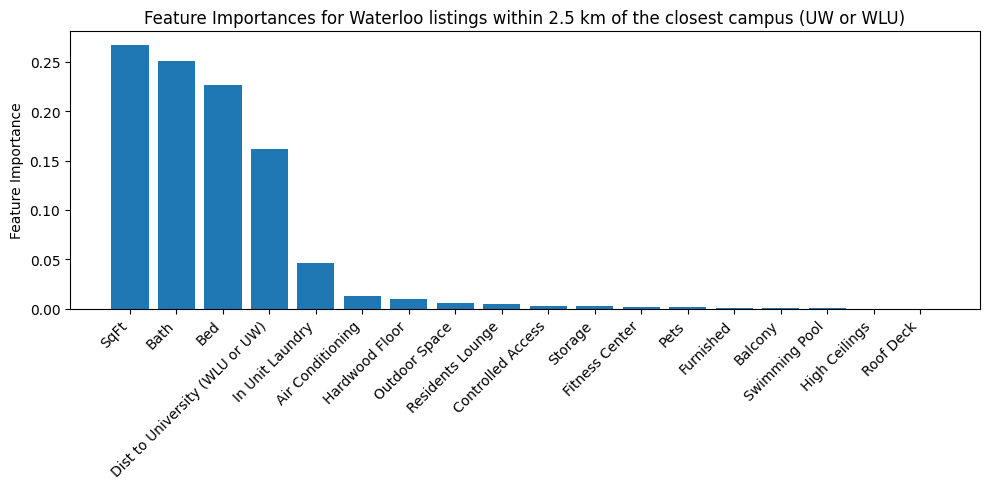

                           feature  importance
2                             SqFt    0.267408
1                             Bath    0.251129
0                              Bed    0.226846
4   Dist to University (WLU or UW)    0.161853
17                 In Unit Laundry    0.046393
12                Air Conditioning    0.012729
15                  Hardwood Floor    0.009534
7                    Outdoor Space    0.006214
8                 Residents Lounge    0.005221
5                Controlled Access    0.003199
10                         Storage    0.002954
6                   Fitness Center    0.001521
3                             Pets    0.001438
14                       Furnished    0.001244
13                         Balcony    0.001204


In [26]:
df_w = df.loc[df["City"].eq("Waterloo")].copy()

df_w["Sqft (Standardized by beds)"] = np.where(
    df_w["Bed"] > 0,
    df_w["SqFt"] / df_w["Bed"],
    df_w["SqFt"]  # for studios, just use total SqFt since we can't divide by 0
)
df_w = df_w.drop(columns=["SqFt"])
df_w = df_w.rename(columns={"Sqft (Standardized by beds)": "SqFt"})

_locmask = df_w["Latitude"].notna() & df_w["Longitude"].notna()
precision = 6
df_w["geohash6"] = np.nan
df_w.loc[_locmask, "geohash6"] = [
    geohash_encode(a, b, precision)
    for a, b in zip(df_w.loc[_locmask, "Latitude"], df_w.loc[_locmask, "Longitude"])
]

df_w["Location (Random Forest)"] = pd.Categorical(df_w["geohash6"]).codes  # -1 if NaN

UW_LAT, UW_LON = 43.4723, -80.5449  # degrees
WLU_LAT, WLU_LON = 43.4738, -80.5275  # degrees

def haversine_km(lat1, lon1, lat2, lon2):
    """Vectorized great-circle distance in kilometers."""
    R = 6371.0088  # mean Earth radius (km)
    lat1 = np.radians(lat1); lon1 = np.radians(lon1)
    lat2 = np.radians(lat2); lon2 = np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    return 2 * R * np.arcsin(np.sqrt(a))

# Distances to each campus (vectorized)
d_uw = haversine_km(
    df_w.loc[_locmask, "Latitude"].to_numpy(),
    df_w.loc[_locmask, "Longitude"].to_numpy(),
    UW_LAT, UW_LON
)
d_wlu = haversine_km(
    df_w.loc[_locmask, "Latitude"].to_numpy(),
    df_w.loc[_locmask, "Longitude"].to_numpy(),
    WLU_LAT, WLU_LON
)

# Overwrite the column with the minimum of the two
df_w.loc[_locmask, "Dist to University (WLU or UW)"] = np.minimum(d_uw, d_wlu)

# (Optional) which campus is nearer?
df_w.loc[_locmask, "Nearest campus"] = np.where(d_uw <= d_wlu, "UW", "WLU")

# df_w["Dist to UW (km)"] = np.nan
# df_w.loc[_locmask, "Dist to UW (km)"] = haversine_km(
#     df_w.loc[_locmask, "Latitude"].to_numpy(),
#     df_w.loc[_locmask, "Longitude"].to_numpy(),
#     UW_LAT, UW_LON
# )

# Within 2.5 km of either campus
df_w = df_w[df_w["Dist to University (WLU or UW)"] <= 2.5] 

feature_cols_rf = [
    "Bed", "Bath", "SqFt", "Pets",
    # "Location (Random Forest)",     
    "Dist to University (WLU or UW)"               
] + amenity_cols

X_all = df_w[feature_cols_rf].copy().replace({np.inf: np.nan, -np.inf: np.nan})
for c in feature_cols_rf:
    if X_all[c].isna().any():
        X_all[c] = X_all[c].fillna(X_all[c].median())

y_all = y.loc[df_w.index]

# train_idx_w = X_train.index.intersection(df_w.index)
# test_idx_w  = X_test.index.intersection(df_w.index)

# X_train_rf = X_all.loc[train_idx_w]
# X_test_rf  = X_all.loc[test_idx_w]
# y_train_w  = y_train.loc[train_idx_w]
# y_test_w   = y_test.loc[test_idx_w]

from sklearn.model_selection import train_test_split
X_train_rf, X_test_rf, y_train_w, y_test_w = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42
)

rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_rf, y_train_w)
rf_pred = rf.predict(X_test_rf)

print("Random Forest R^2:", round(r2_score(y_test_w, rf_pred), 3))
print("Random Forest MAE:", round(mean_absolute_error(y_test_w, rf_pred), 2))

rf_importance_df = pd.DataFrame({
    "feature": feature_cols_rf,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

plt.figure(figsize=(10,5))
plt.bar(rf_importance_df["feature"], rf_importance_df["importance"])
plt.xticks(rotation=45, ha='right')
plt.ylabel("Feature Importance")
plt.title("Feature Importances for Waterloo listings within 2.5 km of the closest campus (UW or WLU)")
plt.tight_layout()
plt.show()

print(rf_importance_df.head(15))


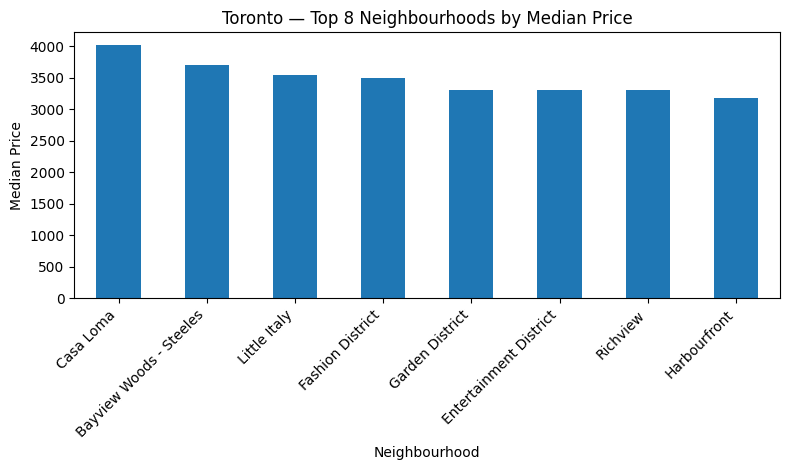

C:\Users\JackE\AppData\Local\Temp\ipykernel_1636\3030405115.py:83: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=keep, showfliers=False)


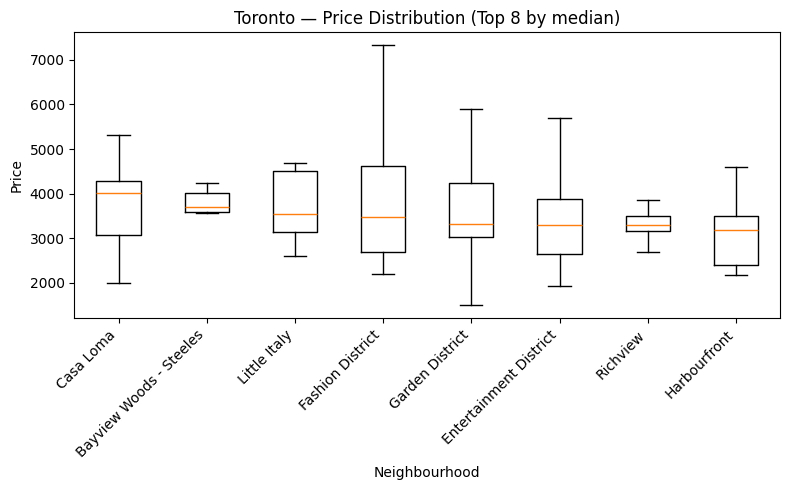

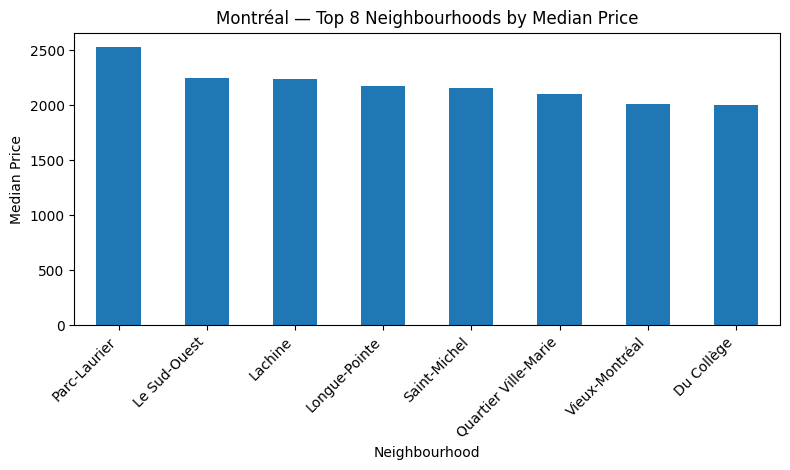

C:\Users\JackE\AppData\Local\Temp\ipykernel_1636\3030405115.py:83: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=keep, showfliers=False)


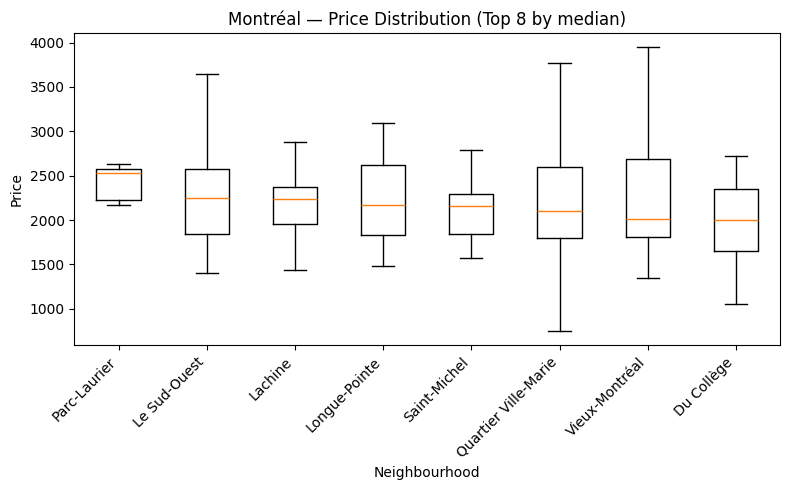

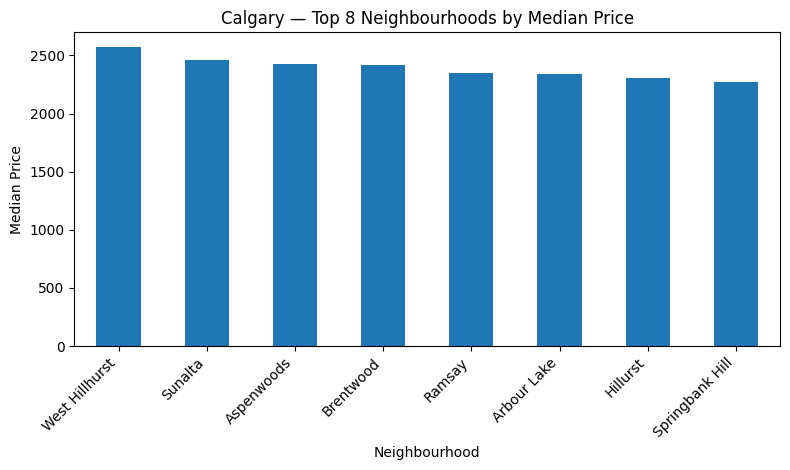

C:\Users\JackE\AppData\Local\Temp\ipykernel_1636\3030405115.py:83: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=keep, showfliers=False)


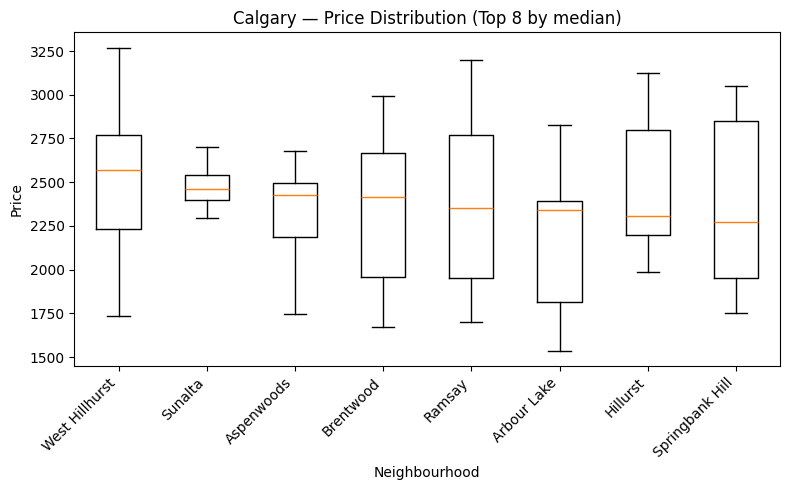

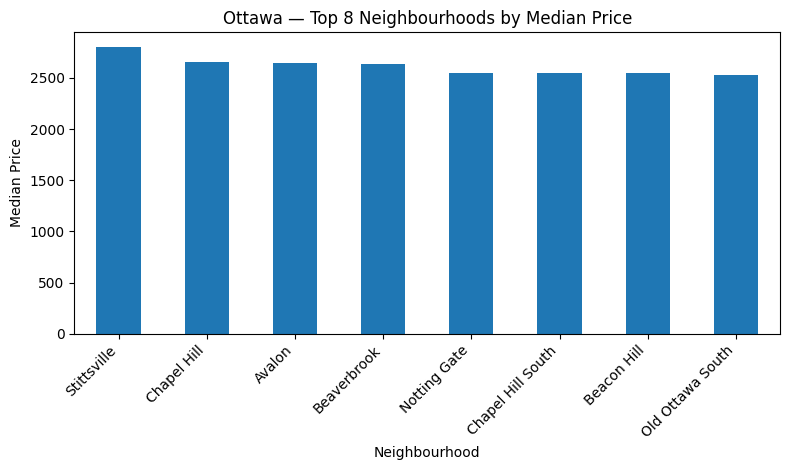

C:\Users\JackE\AppData\Local\Temp\ipykernel_1636\3030405115.py:83: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=keep, showfliers=False)


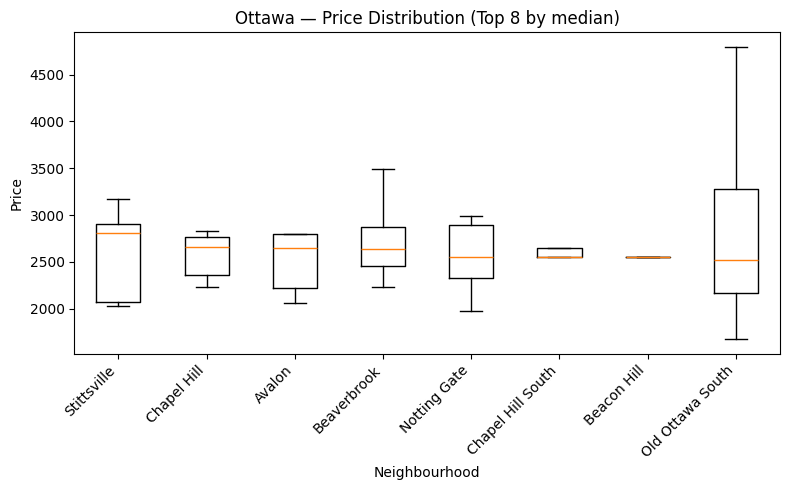

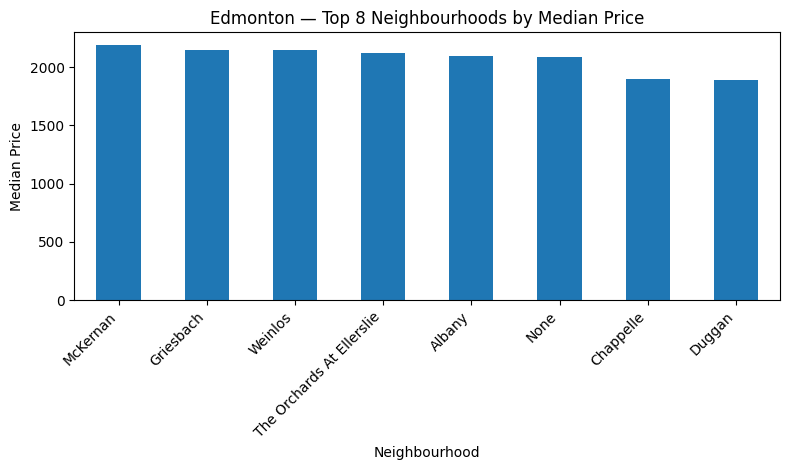

C:\Users\JackE\AppData\Local\Temp\ipykernel_1636\3030405115.py:83: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=keep, showfliers=False)


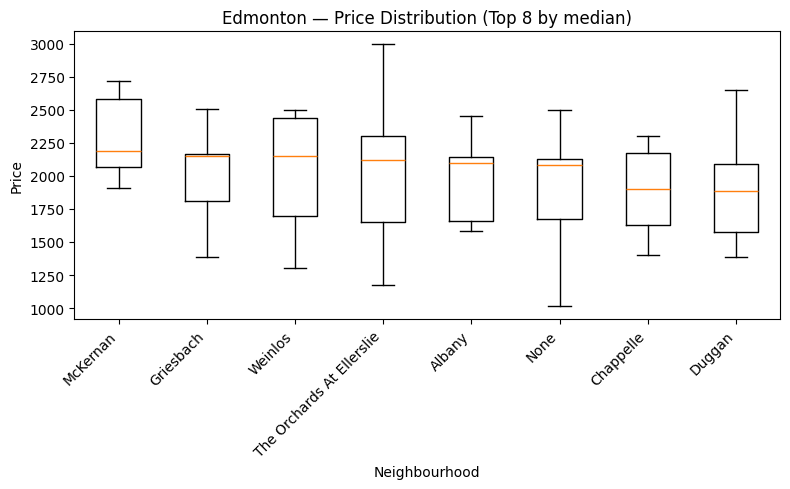

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from openpyxl import load_workbook
import pandas as pd

xlsx_path = "PadmapperData/Padmapper2025.xlsx"
min_n_per_neighbourhood = 5
top_k_neighbourhoods_per_city = 8
num_cities = 5 

out_dir = "NeighbourhoodSummary"

# Headers
wb = load_workbook(filename=str(xlsx_path), read_only=True, data_only=True)
ws = wb[wb.sheetnames[0]]
header = next(ws.iter_rows(min_row=1, max_row=1, values_only=True))
cols = [str(c) if c is not None else "" for c in header]

price_idx = 11
hood_idx  = 1
city_idx  = 3

# Stream rows
prices, hoods, cities = [], [], []
for row in ws.iter_rows(min_row=2, values_only=True):
    p = row[price_idx] 
    h = row[hood_idx] 
    c = row[city_idx]
    prices.append(p)
    hoods.append(str(h).strip())
    cities.append(str(c).strip())

df = pd.DataFrame({"City": cities, "Neighbourhood": hoods, "Price": prices})

# Summary
summary = (
    df.groupby(["City", "Neighbourhood"])["Price"]
      .agg(n="count", mean="mean", median="median", std="std")
      .reset_index()
)
summary_csv = out_dir + "/city_neighbourhood_price_summary.csv"
summary.to_csv(summary_csv, index=False)

# Top cities by listings
city_counts = df["City"].value_counts()
top_cities = city_counts.head(num_cities).index.tolist()

# Table of top-K per city (by median)
tables = []
for city in top_cities:
    sub = summary[(summary["City"] == city) & (summary["n"] >= min_n_per_neighbourhood)].copy()
    if sub.empty:
        continue
    sub = sub.sort_values("median", ascending=False).head(top_k_neighbourhoods_per_city)
    sub.insert(0, "Rank", range(1, len(sub) + 1))
    tables.append(sub)

topk_table = pd.concat(tables, ignore_index=True)

for city in top_cities:
    df_c = df[df["City"] == city]
    counts = df_c["Neighbourhood"].value_counts()
    eligible = counts[counts >= min_n_per_neighbourhood].index.tolist()
    if not eligible:
        continue
    med = df_c.groupby("Neighbourhood")["Price"].median().loc[eligible].sort_values(ascending=False)
    keep = med.head(top_k_neighbourhoods_per_city).index.tolist()

    # Bar chart
    med_keep = med.loc[keep]
    plt.figure(figsize=(max(8, len(keep)*0.7), 4.8))
    med_keep.plot(kind="bar")
    plt.ylabel("Median Price")
    plt.xlabel("Neighbourhood")
    plt.title(f"{city} — Top {len(keep)} Neighbourhoods by Median Price")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Boxplot
    data = [df_c.loc[df_c["Neighbourhood"] == h, "Price"].values for h in keep]
    plt.figure(figsize=(max(8, len(keep)*0.7), 5.0))
    plt.boxplot(data, labels=keep, showfliers=False)
    plt.xlabel("Neighbourhood")
    plt.ylabel("Price")
    plt.title(f"{city} — Price Distribution (Top {len(keep)} by median)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
